In [37]:
from requests import Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import requests
import json
from dotenv import load_dotenv
import os
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv()
API_KEY = os.getenv("COINMARKET_API")

base_url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/"

session = Session()
session.headers.update({"Accepts": "application/json", "X-CMC_PRO_API_KEY": API_KEY})


def fetch_data(endpoint, params):
    try:
        response = session.get(base_url + endpoint, params=params)
        response.raise_for_status()
        return response.json()
    except (ConnectionError, Timeout, TooManyRedirects, requests.HTTPError) as e:
        print(f"Error fetching {endpoint}: {e}")
        return None


params_quotes = {"symbol": "BTC,ETH,ADA", "convert": "USD"}
data_quotes = fetch_data("quotes/latest", params_quotes)

params_listings = {"start": "1", "limit": "10", "convert": "USD", "sort": "market_cap"}
data_listings = fetch_data("listings/latest", params_listings)

if data_quotes:
    print("Quotes Keys")
    pprint(data_quotes.keys())
    print("\nQuote data (BTC example):")
    pprint(data_quotes["data"]["BTC"]["quote"]["USD"])

if data_listings:
    print("\nListings Keys")
    print("Number of coins:", len(data_listings["data"]))
    first_coin = data_listings["data"][0]
    print("First coin:", first_coin["name"], "-", first_coin["symbol"])
    pprint(first_coin["quote"]["USD"])

if data_listings and "data" in data_listings:
    df_listings = pd.json_normalize(data_listings["data"])
    print("\nListings DataFrame:")
    display(
        df_listings[
            ["name", "symbol", "quote.USD.price", "quote.USD.market_cap"]
        ].head(10)
    )

Quotes Keys
dict_keys(['status', 'data'])

Quote data (BTC example):
{'fully_diluted_market_cap': 2341694152126.3,
 'last_updated': '2025-10-25T15:48:00.000Z',
 'market_cap': 2223468816449.41,
 'market_cap_dominance': 59.1563,
 'percent_change_1h': -0.09787998,
 'percent_change_24h': 1.35622864,
 'percent_change_30d': 0.0372258,
 'percent_change_60d': 1.70333789,
 'percent_change_7d': 4.23380083,
 'percent_change_90d': -5.87139392,
 'price': 111509.24533934769,
 'tvl': None,
 'volume_24h': 29947388158.144913,
 'volume_change_24h': -44.7146}

Listings Keys
Number of coins: 10
First coin: Bitcoin - BTC
{'fully_diluted_market_cap': 2341592756893.62,
 'last_updated': '2025-10-25T15:47:00.000Z',
 'market_cap': 2223372540367.496,
 'market_cap_dominance': 59.1586,
 'percent_change_1h': -0.10108471,
 'percent_change_24h': 1.3395353,
 'percent_change_30d': 0.12719714,
 'percent_change_60d': 1.645885,
 'percent_change_7d': 4.21857808,
 'percent_change_90d': -5.86265977,
 'price': 111504.41699493

,name,symbol,quote.USD.price,quote.USD.market_cap
0,Bitcoin,BTC,111504.416995,2.223373e+12
1,Ethereum,ETH,3932.509909,4.746471e+11
2,Tether USDt,USDT,1.000070,1.829033e+11
3,XRP,XRP,2.605668,1.563851e+11
4,BNB,BNB,1110.632686,1.545776e+11
5,Solana,SOL,192.305949,1.056636e+11
6,USDC,USDC,0.999872,7.630238e+10
7,Dogecoin,DOGE,0.196701,2.979990e+10
8,TRON,TRX,0.298021,2.821239e+10
9,Cardano,ADA,0.652935,2.340817e+10


In [47]:
df_listings[
    [
        "name",
        "quote.USD.percent_change_1h",
        "quote.USD.percent_change_24h",
        "quote.USD.percent_change_7d",
    ]
]

,name,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d
0,Bitcoin,-0.101085,1.339535,4.218578
1,Ethereum,-0.124918,1.085004,1.410918
2,Tether USDt,-0.013161,-0.019968,-0.045584
3,XRP,-0.290766,5.098477,10.953271
4,BNB,-0.172688,0.388660,1.594237
5,Solana,-0.222055,1.601866,3.801967
6,USDC,-0.006703,-0.010798,-0.012226
7,Dogecoin,-0.237449,0.836497,4.886953
8,TRON,0.140712,-3.174457,-4.995491
9,Cardano,-0.159402,1.078462,3.295790


In [ ]:
df_clean = df_listings.copy()

price_cols = [col for col in df_clean.columns if col.startswith("quote.USD.")]
new_col_names = {col: col.replace("quote.USD.", "") for col in price_cols}
df_clean.rename(columns=new_col_names, inplace=True)

df_analysis = df_clean[
    [
        "name",
        "symbol",
        "cmc_rank",
        "price",
        "market_cap",
        "percent_change_24h",
        "percent_change_7d",
        "volume_24h",
        "circulating_supply",
        "total_supply",
    ]
].copy()

df_analysis["volatility_7d"] = df_analysis["percent_change_7d"].abs()

print("\nDataFrame efter rensning och nyckeltal:")
display(df_analysis.sort_values(by="cmc_rank").head())


DataFrame efter rensning och nyckeltal:


,name,symbol,cmc_rank,price,market_cap,percent_change_24h,percent_change_7d,volume_24h,circulating_supply,total_supply,volatility_7d
0,Bitcoin,BTC,1,111504.416995,2.223373e+12,1.339535,4.218578,2.997478e+10,1.993977e+07,1.993977e+07,4.218578
1,Ethereum,ETH,2,3932.509909,4.746471e+11,1.085004,1.410918,1.872094e+10,1.206983e+08,1.206983e+08,1.410918
2,Tether USDt,USDT,3,1.000070,1.829033e+11,-0.019968,-0.045584,7.819566e+10,1.828905e+11,1.859792e+11,0.045584
3,XRP,XRP,4,2.605668,1.563851e+11,5.098477,10.953271,4.165940e+09,6.001728e+10,9.998578e+10,10.953271
4,BNB,BNB,5,1110.632686,1.545776e+11,0.388660,1.594237,2.470468e+09,1.391798e+08,1.391798e+08,1.594237



Statistisk sammanfattning för procentuella förändringar:


,percent_change_24h,percent_change_7d
count,10.000000,10.000000
mean,0.822328,2.510841
std,2.023785,4.128710
min,-3.174457,-4.995491
25%,0.089067,0.343560
50%,0.957480,2.445013
75%,1.275902,4.114425
max,5.098477,10.953271


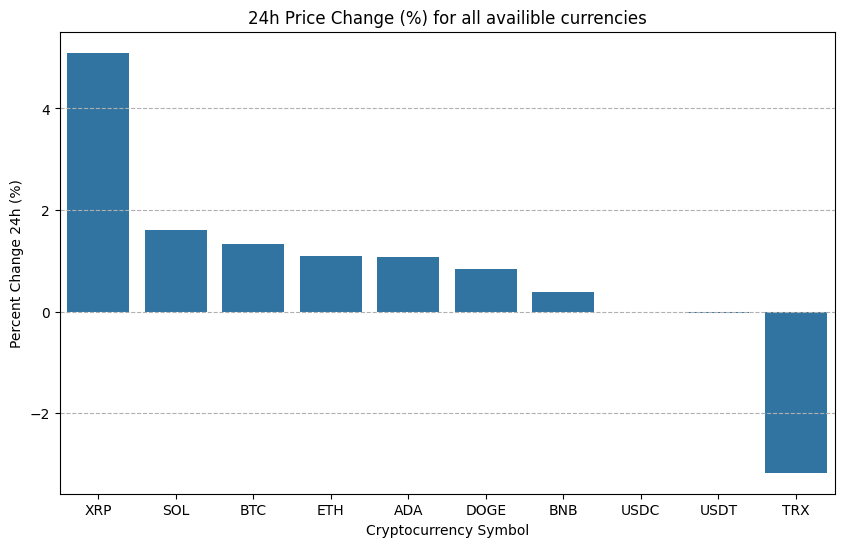

In [ ]:
print("\nStatistisk sammanfattning för procentuella förändringar:")
display(df_analysis[["percent_change_24h", "percent_change_7d"]].describe())

plt.figure(figsize=(10, 6))
sns.barplot(
    x="symbol",
    y="percent_change_24h",
    data=df_analysis.sort_values(by="percent_change_24h", ascending=False),
)
plt.title("24h Price Change (%) for all available currencies")
plt.ylabel("Percent Change 24h (%)")
plt.xlabel("Cryptocurrency Symbol")
plt.grid(axis="y", linestyle="--")
plt.show()